# Make sure you have the following (built-in) libraries

* math
* time
* matplotlib
* ast

# Enter the location of spline0.txt

In [ ]:
LOCATION = "../spline0.txt"

In [3]:
import math
import time

class Vector(tuple):
    """Subclass of tuples to allow rudimentary vector operations."""
    def __init__(self, coord=(0,0)): # type: (Iterable[float, float]) -> None
        self.x = float(coord[0])
        self.y = float(coord[1])

    def dist(self, other):
        if not isinstance(other, Vector):
            raise TypeError("Distance can only be calculated between two Vectors")
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    @property
    def r(self):
        return math.sqrt(self.x**2 + self.y**2)
    @property
    def theta(self):
        return math.degrees(math.atan2(self.x, self.y)) # Clockwise from +y
    
    def __add__(self, other):
        if isinstance(other, Vector):
            return Vector((self.x + other.x, self.y + other.y))
        raise TypeError("Unsupported operand type(s) for +: 'Vector' and '{}'".format(type(other).__name__))  
    def __sub__(self, other):
        if isinstance(other, Vector):
            return Vector((self.x - other.x, self.y - other.y))
        raise TypeError("Unsupported operand type(s) for -: 'Vector' and '{}'".format(type(other).__name__))
    def __mul__(self, scalar):
        if isinstance(scalar, (int, float)):
            return Vector((self.x * scalar, self.y * scalar))
        raise TypeError("Unsupported operand type(s) for *: 'Vector' and '{}'".format(type(scalar).__name__))
    def __truediv__(self, scalar):
        if isinstance(scalar, (int, float)):
            return Vector((self.x / scalar, self.y / scalar))
        raise TypeError("Unsupported operand type(s) for /: 'Vector' and '{}'".format(type(scalar).__name__))
    def __floordiv__(self, scalar):
        if isinstance(scalar, (int, float)):
            return Vector((self.x // scalar, self.y // scalar))
        raise TypeError("Unsupported operand type(s) for //: 'Vector' and '{}'".format(type(scalar).__name__))
    def __eq__(self, other):
        if isinstance(other, Vector):
            return self.x == other.x and self.y == other.y
        return False
    def __repr__(self):
        return "Vector({}, {})".format(self.x, self.y)
    
def Bez(t, A: Vector, B: Vector, C: Vector, D: Vector) -> Vector:
    """Bernstein polynomial form for parametric cubic Bezier curves."""
    return A*(1-t)**3 + B*3*t*(1-t)**2 + C*3*t**2*(1-t) + D*t**3

def BezDer(t, A: Vector, B: Vector, C: Vector, D: Vector) -> Vector:
    """First derivative of Bernstein polynomial form for parametric cubic Bezier curves."""
    return (B - A)*3*(1-t)**2 + (C - B)*2*t*(1-t) + (D - C)*t**2

def BisectGeneric(getter, domain, target):
    """
    Semi-discrete binary (bisection) search over a
    generic 2D set. Getter must be valid for items
    in the domain, where the domain is an iterable
    sorted least-to-greatest.
    """
    low = 0
    high = len(domain) - 1
    while low < high:
        mid = low + (high - low) // 2
        if getter(mid) == target:
            return mid
        elif getter(mid) < target:
            low = mid + 1
        else:
            high = mid - 1
    return mid

VPOSEEPSILON = 60
ROTEPSILON = 1
SUBDIVRESOLUTION = 150

In [ ]:
# region Objective Definitions
class Objective():
    """Generic target; Please don't initialize without subclassing."""
    def activate(self, state): # type: (State) -> None
        pass

    def completed(self, state): # type: (State) -> bool
        return True
    
class VPoseObjective(Objective):
    """A V-POSE (velocity + position + rotation) target from a curve."""
    def __init__(self, vel, pos, rot): # type: (int, Vector, float) -> None
        self.vel = vel
        self.pos = pos
        self.rot = rot

    def completed(self, state): # type: (State) -> bool
        return self.pos.dist(state.pos) <= VPOSEEPSILON
    
class DriveObjective(Objective):
    """Allows for direct control of driving (both forwards and backwards)."""
    def __init__(self, dist): # type: (float) -> None
        self.dist = dist
    
    def activate(self, state): # type: (State) -> None
        self.pos = state.pos

    def completed(self, state): # type: (State) -> bool
        return self.pos.dist(state.pos) >= self.dist

class RotationObjective(Objective):
    """A target heading."""
    def __init__(self, rot): # type: (float) -> None
        self.rot = rot

    def completed(self, state):
        return -ROTEPSILON <= self.rot - state.rot <= ROTEPSILON

class RoutineObjective(Objective):
    """A wildcard routine (e.g. intake) to perform."""
    def __init__(self, callback): # type: (Callable) -> None
        self.callback = callback # callback triggers the routine; this could be considered the most generic usuable routine

    def activate(self, state):
        self.callback()

class DelayObjective(Objective):
    """A pause for a specified amount of time."""
    def __init__(self, duration): # type: (int) -> None
        self.t = False
        self.duration = duration

    def activate(self, state):
        self.t = time.time() * 1000

    def completed(self, _):
        return self.t and time.time() * 1000 - self.t >= self.duration
    
class PrintObjective(Objective):
    """Prints a message to the brain screen."""
    def __init__(self, message): # type: (str) -> None
        self.message = message

    def activate(self, state):
        brain.screen.clear_screen()
        brain.screen.print(self.message)

# endregion Objective Definitions

class Path():
    """Manages the objectives for the robot to follow. Beware: Heavy
    multivar-calc, arc-length parametrization, and splines inside!"""
    def __init__(self, objectives): # type: (list[Objective]) -> None
        self.objectives = objectives

    @staticmethod
    def parse(data): # type: (str) -> list[Objective]
        """Parses objectives from stored file data."""
        lines = map(str.upper, map(lambda x: str.replace(x, " ", ""), data.split("\n")))
        out = []
        vel = 100
        for line in lines:
            print(line)
            if not line or line[0] == "#":
                continue
            line = line.split(":", 1)
            if line[0] == "CURVE":
                a, b, c, d = map(Vector, map(lambda x: str.split(x, ","), line[1].replace("(","").replace(")","").split("|")))
                arclength = Path._arcLength(lambda t: Path.Bez(t, a, b, c, d))
                for i in range(math.ceil(arclength/SUBDIVRESOLUTION)+1):
                    i /= math.ceil(arclength/SUBDIVRESOLUTION) # math.ceil(...) is the number of subdivisions to make
                    out.append(VPoseObjective(vel, Path.Bez(i, a, b, c, d), Path.BezDer(i, a, b, c, d).theta))

            elif line[0] == "CMD":
                left, right = line[1].split("=", 1)
                if left == "SET_VELOCITY":
                    vel = int(right)
                elif left == "TURN_HEADING":
                    out.append(RotationObjective(float(right)))
                elif left == "DRIVE":
                    out.append(DriveObjective(float(right)))
                elif left == "ROUTINE":
                    routines = {
                        "PICK_UP": print,
                        "PUT_DOWN": print,
                        #"STORE": store,
                        "PUT_TOP": print,
                        "PUT_MIDDLE": print,
                        "STOP_INTAKE": print
                        }
                    out.append(RoutineObjective(routines[right]))
                elif left == "DELAY":
                    out.append(DelayObjective(int(right)))
                elif left == "PRINT":
                    out.append(PrintObjective(right.strip()))
                else:
                    raise ValueError("Invalid CMD \"{}\"!".format(left))
            else:
                raise ValueError("Unrecognized action \"{}\"!".format(line[0]))
        return out
    
    @staticmethod
    def _arcLength(curveFunc): #type: (Callable) -> float
        """Estimates the arc length of a curve."""
        return sum(curveFunc(x/20).dist(curveFunc((x+1)/20)) for x in range(20))
    
    @property
    def currentObjective(self): # type: () -> Objective | None
        """Returns the first objective, or None if none exist."""
        return self.objectives[0] if len(self.objectives) > 0 else None
    
    def advanceObjectives(self, state): #type: (State) -> None
        """Discards completed objectives from start of queue; activates new objectives as necessary."""
        while self.currentObjective:
            self.currentObjective.activate(state)
            if self.currentObjective.completed(state):
                self.objectives.pop(0)
    
    @staticmethod
    def Bez(t, A, B, C, D): # type: (float, Vector, Vector, Vector, Vector) -> Vector
        """Bernstein polynomial form for parametric cubic Bezier curves."""
        return A*(1-t)**3 + B*3*t*(1-t)**2 + C*3*t**2*(1-t) + D*t**3
    
    @staticmethod
    def BezDer(t, A, B, C, D): # type: (float, Vector, Vector, Vector, Vector) -> Vector
        """First derivative of Bernstein polynomial form for parametric cubic Bezier curves."""
        return (B - A)*3*(1-t)**2 + (C - B)*2*t*(1-t) + (D - C)*t**2
    
    @staticmethod
    def HBez(t, A, va, vd, D): # type: (float, Vector, Vector, Vector, Vector) -> Vector
        """Hermite variant of connected cubic Bezier curves."""
        return Path.Bez(t, A, A+va/3, D-vd/3, D)
    
    @staticmethod
    def HBezDer(t, A, va, vd, D): # type: (float, Vector, Vector, Vector, Vector) -> Vector
        """First derivative of hermite varient of connected cubic bezier curves"""
        return Path.BezDer(t, A, A+va/3, D-vd/3, D)


fin = open(LOCATION, "r")
data = fin.read()
fin.close()
p = Path(Path.parse(data))
p.objectives

#FORMAT:
##COMMENTBLAHBLAH
#CURVE:[START_POINT]|[CTRL_POINT1]|[CTRL_POINT1]|[END_POINT]
##EX.CURVE:(2.23,0.34)|(3.35,-2)|(2.3,5.4)|(6.5)
#CMD:SET_VELOCITY={1-100(%)}
#CMD:TURN_HEADING={0-359(DEG)}
#CMD:ROUTINE={PICK_UP,PUT_DOWN,PUT_TOP,PUT_MIDDLE,STOP_INTAKE}
#CMD:DELAY={0-INF(MSEC)}
#CMD:DRIVE={+/-DISTANCE(MM)}

CMD:SET_VELOCITY=75
CURVE:(-1390,-390)|(-926.7766566675756,-381.3771475320424)|(-1077.7174802290701,-741.9580038178345)|(-859.6918461958004,-934.8268339241885)
CMD:TURN_HEADING=45
CURVE:(-859.6918461958004,-934.8268339241885)|(-802.390237251159,-846.7780201799834)|(-745.0886283065176,-758.7292064357783)|(-687.7870193618762,-670.6803926915733)
CMD:ROUTINE=PICK_UP
CMD:SET_VELOCITY=50
CURVE:(-687.7870193618762,-670.6803926915733)|(-596.9430051813472,-586.8243796018542)|(-506.09899100081816,-502.96836651213505)|(-415.2549768202891,-419.112353422416)
CMD:ROUTINE=STOP_INTAKE
CURVE:(-415.2549768202891,-419.112353422416)|(-350.96531788019274,-357.61790228161067)|(-286.67565894009635,-

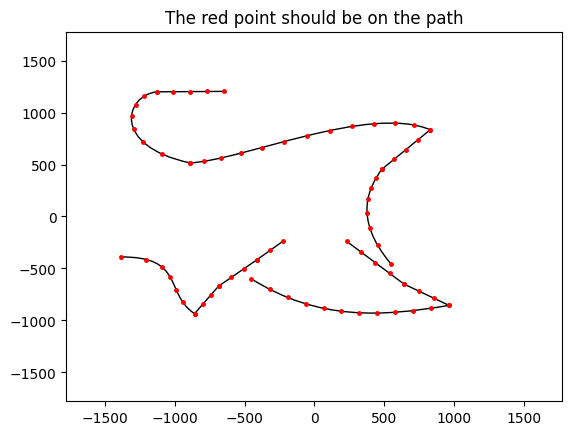

In [5]:
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import matplotlib.path as mpath
#from bisect import bisect_left
#import numpy as np
from ast import literal_eval as make_tuple

Path = mpath.Path

#plt.ion()

fig, ax = plt.subplots()
ax.set_xlim(-1778,1778)
ax.set_ylim(-1778,1778)

for line in data.splitlines():
    line = line.replace(" ","").upper().split(":")
    #print(line)
    if line[0] == "CURVE":
        points = tuple(map(make_tuple, line[1].split("|")))

        #print(points)

        pp1 = mpatches.PathPatch(
            Path(points,
                [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]),
            fc="none", transform=ax.transData)

        ax.add_patch(pp1)
        #ax.plot(*zip(*[Bez(t, *map(Vector, points)) for t in [i/10 for i in range(11)]]), "sr")
for objective in p.objectives:
    if isinstance(objective, VPoseObjective):
        ax.plot(objective.pos.x, objective.pos.y, "r.", markersize=5)

ax.set_title('The red point should be on the path')

fin.close()

#
#subdivs = 10
#
#n = subdivs * 3
#ts = [i/n for i in range(n+1)] # Plural of t
#px, py = zip(*[Bez(t,*map(Vector, points)) for t in ts])
#ax.plot(px, py, ".b", markersize=0.5)
#
#epsilon = 1
#arclengths = [np.trapezoid([Vector((x,y)).r for x,y in zip(px,py)], dx=1/n)]
#ts = ts




#plt.clf()
plt.show()